In [ ]:
# IN GOOGLE COLAB:
####################################################################################################################################################
## STEP 1: Make the ZIP file public on Google Drive and copy the link ID:
# Example: https://drive.google.com/file/d/1LPTpBnfkl7tWDifJD5CLQUnNO8nvsDZX/view?usp=sharing
# ID: 1LPTpBnfkl7tWDifJD5CLQUnNO8nvsDZX
####################################################################################################################################################
## STEP 2: Download the ZIP from Google Drive using the link ID:
#!gdown --id 1LPTpBnfkl7tWDifJD5CLQUnNO8nvsDZX
####################################################################################################################################################
## STEP 3: Unzip the ZIP file:
#!unzip /content/Chars74k_Version.zip
####################################################################################################################################################
## STEP 4 (not necessary): Change the working directory
#%cd Chars74k_Version
#!pwd #Check that you are in the desired directory
#!ls #See the files inside
####################################################################################################################################################

In [8]:
####################################################################################################################################################
## LIBRARIES:
import os
import tensorflow as tf
from tensorflow import keras
####################################################################################################################################################
## FUNCTIONS:
def model_assembler():

    # Load the input layer and data augmentation layers [1/8 -> pi/4] (slightly less rotation is applied):
    input_ly = keras.Input(shape=[64, 64, 1], dtype=tf.float32)
    aug_ly = keras.layers.RandomRotation(factor=(-1/20, 1/20), fill_mode="nearest", interpolation="nearest", seed=177)(input_ly)
    aug_ly = keras.layers.RandomZoom(height_factor=(0, 0.05), width_factor=None, fill_mode="nearest", interpolation="nearest", seed=177)(aug_ly)
    aug_ly = keras.layers.RandomTranslation(height_factor=(0, 0.05), width_factor=(0, 0.05), fill_mode="nearest", interpolation="nearest", seed=177)(aug_ly)
    
    # Add the first convolutional layer:
    conv1_ly = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu")(aug_ly)
    conv1_ly = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1_ly)

    # Add the second convolutional layer:
    conv2_ly = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu")(conv1_ly)
    conv2_ly = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2_ly)

    # Add the third convolutional layer:
    conv3_ly = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu")(conv2_ly)
    conv3_ly = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3_ly)

    # Regularize from convolutional to dense layers and apply dropout:
    dropout_ly = keras.layers.Dropout(rate=0.5, seed=117)(conv3_ly)
    dense_ly = keras.layers.Flatten()(dropout_ly)

    # Add dense layers and the output for 62 classes:
    dense1_ly = keras.layers.Dense(units=150, activation="relu")(dense_ly)
    output_ly = keras.layers.Dense(units=62, activation="softmax")(dense1_ly)
    
    # Create the model and return:
    model = keras.Model(inputs=input_ly, outputs=[output_ly], name="TFM_Charts74k")
    return model
####################################################################################################################################################
## MAIN: Create the model and visualize its structure

# Get the working directory:
work_path = os.getcwd()

# Create the model and visualize:
Chars74k_model = model_assembler()
Chars74k_model.summary()
keras.utils.plot_model(Chars74k_model, to_file=os.path.join(work_path, "TFM_Chars74k_diagram.pdf"), show_shapes=True, show_layer_names=True,
                       expand_nested=True, dpi=100, show_layer_activations=True)

Model: "TFM_Charts74k"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_LY (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 64, 64, 1)        0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 64, 64, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 dropout_6 (Dropout)         (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                 

In [ ]:
####################################################################################################################################################
## LIBRARIES:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
####################################################################################################################################################
## FUNCTIONS:

# Function 1: Image preprocessing for neural network input:
def preprocess_data(raw_x):
    
    # Normalize values from [0-255] to [0-1]:
    norm_x = keras.layers.Rescaling(1./255)(raw_x)
    
    # Invert values of background and character:
    inver_x = keras.layers.Lambda(lambda x: 1 - x)(norm_x)
    
    # NOTE: Originally, the Chars74k dataset has characters in black and the background in white. The decision is made
    # to switch to the "EMNIST" format, which is the opposite.
    
    # Return the transformation:
    return inver_x

# Function 2: Create the neural network model:
def model_assembler():

    # Load the input layer and data augmentation layers [1/8 -> pi/4] (slightly less rotation is applied):
    input_ly = keras.Input(shape=[64, 64, 1], dtype=tf.float32)
    aug_ly = keras.layers.RandomRotation(factor=(-1/20, 1/20), fill_mode="nearest", interpolation="nearest", seed=177)(input_ly)
    aug_ly = keras.layers.RandomZoom(height_factor=(0, 0.05), width_factor=None, fill_mode="nearest", interpolation="nearest", seed=177)(aug_ly)
    aug_ly = keras.layers.RandomTranslation(height_factor=(0, 0.05), width_factor=(0, 0.05), fill_mode="nearest", interpolation="nearest", seed=177)(aug_ly)
    
    # Add the first convolutional layer:
    conv1_ly = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu")(aug_ly)
    conv1_ly = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1_ly)

    # Add the second convolutional layer:
    conv2_ly = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu")(conv1_ly)
    conv2_ly = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2_ly)

    # Add the third convolutional layer:
    conv3_ly = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu")(conv2_ly)
    conv3_ly = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3_ly)

    # Regularize from convolutional to dense layers and apply dropout:
    dropout_ly = keras.layers.Dropout(rate=0.5, seed=117)(conv3_ly)
    dense_ly = keras.layers.Flatten()(dropout_ly)

    # Add dense layers and the output for 62 classes:
    dense1_ly = keras.layers.Dense(units=150, activation="relu")(dense_ly)
    output_ly = keras.layers.Dense(units=62, activation="softmax")(dense1_ly)
    
    # Create the model and return:
    model = keras.Model(inputs=input_ly, outputs=[output_ly], name="TFM_Charts74k")
    return model
####################################################################################################################################################
## MAIN: Train the model from scratch or continue training

# Get the working directory, the dataset directory, and the checkpoints directory:
work_path = os.getcwd()
dataset_path = os.path.join(work_path, "Chars74k_Dataset")
ckp_path = os.path.join(work_path, "Chars74k_Model_Ckeckpoints")

# Set the name of the model from which to continue training and the number of epochs:
model_name = "TFM_Chars74k_model_ep100.keras"
num_epoch = 100

# Check if the model is found to continue training or start from scratch:
print("Searching for the model \"{}\" to be trained for {} epochs".format(model_name, num_epoch))
if not os.path.exists(os.path.join(ckp_path, model_name)):

    # If the model is not found, create the model and add the compiler:
    print("\t- The model \"{}\" was not found, so a new model is generated from scratch.\n".format(model_name))
    model_name = "TFM_Chars74k_model_ep0.keras"  # New model from scratch
    EMNIST_model = model_assembler()
    EMNIST_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
else:
    
    # If the model is found, load its last state and add the custom optimizer:
    print("\t- Found the model \"{}\", and training continues from where it left off.\n".format(model_name))
    custom_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    EMNIST_model = keras.models.load_model(os.path.join(ckp_path, model_name), custom_objects={"Custom>Adam": custom_opt})

# Check if a GPU is available for training:
print("Proceeding to train the model, but first, it must be determined whether the GPU is operational:")
if tf.test.gpu_device_name() == "/device:GPU:0":
    
    # If the GPU is active, load the datasets and start training:
    print("\t- GPU is available for training the model \"{}\".".format(model_name))
    with tf.device("/device:GPU:0"):
        
        # Load training and validation datasets and preprocess them:
        print("\t- Loading training and validation datasets:")
        train_ds = keras.utils.image_dataset_from_directory(directory=dataset_path, labels="inferred", label_mode="categorical",
                                                            class_names=os.listdir(dataset_path), color_mode="grayscale", batch_size=128,
                                                            image_size=(64, 64), shuffle=True, seed=117, validation_split=0.2,
                                                            subset="training", interpolation="nearest", crop_to_aspect_ratio=False)
        val_ds = keras.utils.image_dataset_from_directory(directory=dataset_path, labels="inferred", label_mode="categorical",
                                                          class_names=os.listdir(dataset_path), color_mode="grayscale", batch_size=128,
                                                          image_size=(64, 64), shuffle=True, seed=117, validation_split=0.2,
                                                          subset="validation", interpolation="nearest", crop_to_aspect_ratio=False)
        train_ds = train_ds.map(lambda x, y: (preprocess_data(x), y))
        val_ds = val_ds.map(lambda x, y: (preprocess_data(x), y))
        
        # Prepare datasets for neural network input:
        AUTOTUNE = tf.data.AUTOTUNE
        train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
        val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
        
        # Create callbacks used by the model (save the complete model):
        print("\n\t- Loaded the data, loading training callbacks.")
        checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckp_path, "CkeckPoints_epoch{epoch:03d}.keras"),
                                                              save_weights_only=False, monitor="val_accuracy", mode="max", save_best_only=True)
        earlystopp_callback = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)
        
        # Train the model and generate the training history DataFrame:
        print("\t- Proceeding to train the model \"{}\":".format(model_name))
        training_hist = Chars74k_model.fit(train_ds, validation_data=val_ds, epochs=num_epoch, callbacks=[checkpoint_callback, earlystopp_callback])
        hist_df = pd.DataFrame.from_dict(training_hist.history, orient="index").T
        
        # With training completed, determine up to which epoch it was trained and save the weights/model:
        print("\t- Training completed, saving model and data.")
        final_model =  "TFM_Chars74k_model_ep" + str(int((model_name.split("ep")[1]).split(".")[0]) + len(hist_df)) + ".keras"
        Chars74k_model.save(os.path.join(ckp_path, final_model), overwrite=True)
        Chars74k_model.save_weights(os.path.join(ckp_path, final_model.replace("model", "weights").replace("keras", "h5")), overwrite=True)
        
        # Save the training data to a CSV file:
        hist_df.to_csv(os.path.join(ckp_path, "Performance_Data.csv"), sep=chr(9), index=False,
                       header=not os.path.exists(os.path.join(ckp_path, "Performance_Data.csv")))
        print("\nProcess completed.")

Characteristic training data:
	- Training: Detected a maximum "Accuracy" value of 84.53585505485535% in epoch 36.
	- Training: Detected a minimum "Loss" value of 0.406796932220459 in epoch 36.
	- Validation: Detected a maximum "Accuracy" value of 84.01333689689636% in epoch 29.
	- Validation: Detected a minimum "Loss" value of 0.4302156567573547 in epoch 29.


Proceeding to represent training data:



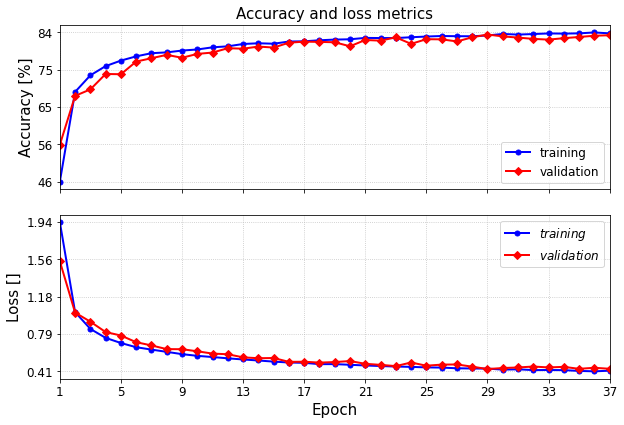

In [1]:
####################################################################################################################################################
## LIBRARIES:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
####################################################################################################################################################
## VISUALIZATION FUNCTIONS:

# Visualization Function 1: Represent training metrics
def model_performance_explorer(csv_file, safe_flag):
    
    # Load data from CSV:
    hist_data = pd.read_csv(csv_file, sep=chr(9))

    # Extract training history data and mark characteristic data:
    epochs = np.arange(1,  hist_data.shape[0] + 1)
    train_loss = np.array(hist_data["loss"])
    val_loss =  np.array(hist_data["val_loss"])
    train_acc = np.array(hist_data["accuracy"])*100
    val_acc =  np.array(hist_data["val_accuracy"])*100
    print("Characteristic training data:")
    print("\t- Training: Detected a maximum \"Accuracy\" value of {}% in epoch {}.".format(np.amax(train_acc), np.argmax(train_acc)+1))
    print("\t- Training: Detected a minimum \"Loss\" value of {} in epoch {}.".format(np.amin(train_loss), np.argmin(train_loss)+1))
    print("\t- Validation: Detected a maximum \"Accuracy\" value of {}% in epoch {}.".format(np.amax(val_acc), np.argmax(val_acc)+1))
    print("\t- Validation: Detected a minimum \"Loss\" value of {} in epoch {}.\n".format(np.amin(val_loss), np.argmin(val_loss)+1))
    
    # Create the figure and subplots for training data representation:
    print("\nProceeding to represent training data:\n")
    fig, axs = plt.subplots(1, 2, figsize=(8.3, 11.7/2))
    # NOTE: An A4 sheet has [210mm X 297mm] or [8.3in X 11.7in] (Width X Height). We want to generate an image of a quarter sheet.

    # Represent data for each subplot ("accuracy" & "loss"):
    axs[0].plot(epochs, train_acc, 'bo-', linewidth=2, markersize=5, label="training")
    axs[0].plot(epochs, val_acc,'rD-', linewidth=2, markersize=5, label="validation")
    axs[0].grid(True, which="both", linestyle=":", alpha=0.8)
    axs[0].set_xlim(1, np.amax(epochs))
    axs[1].plot(epochs, train_loss, 'bo-', linewidth=2, markersize=5, label="$training$")
    axs[1].plot(epochs, val_loss, 'rD-', linewidth=2, markersize=5, label="$validation$")
    axs[1].grid(True, which="both", linestyle=":", alpha=0.8)
    axs[1].set_xlim(1, np.amax(epochs))

    # Identify altered maximum/minimum data for "xticks"/"yticks" of "subplots":
    ep_max = np.max(epochs)
    ep_min = np.min(epochs)
    acc_max = np.max(np.maximum(train_acc, val_acc))
    acc_min = np.min(np.minimum(train_acc, val_acc))
    loss_max = np.max(np.maximum(train_loss, val_loss))
    loss_min = np.min(np.minimum(train_loss, val_loss))

    # Adjust axis representation values for each "subplot":
    axs[0].set_xticks(np.linspace(ep_min, ep_max, num=10))
    axs[0].set_xticklabels([], fontsize=12)
    axs[0].set_yticks(np.linspace(acc_min, acc_max, num=5))
    axs[0].set_yticklabels(axs[0].get_yticks().astype(np.int64), fontsize=12)
    axs[1].set_xticks(np.linspace(ep_min, ep_max, num=10))
    axs[1].set_xticklabels(axs[1].get_xticks().astype(np.int64), fontsize=12)
    axs[1].set_yticks(np.linspace(loss_min, loss_max, num=5))
    axs[1].set_yticklabels(np.round(axs[1].get_yticks(), decimals=2), fontsize=12)

    # Configure "subplots" axes:
    axs[0].set_position([0.06,0.55,0.92,0.39])
    axs[1].set_position([0.06,0.1,0.92,0.39])
    for ax in axs:
        for lb in ["top", "right", "bottom", "left"]:
            ax.spines[lb].set_visible(True)
    axs[0].set_title("Accuracy and loss metrics", fontsize=15)
    axs[0].set_ylabel("Accuracy [%]", fontsize=15)
    axs[0].legend(loc="lower right", fontsize=12)
    axs[1].set_ylabel("Loss []", fontsize=15)
    axs[1].set_xlabel("Epoch", fontsize=15)
    axs[1].legend(loc="upper right", fontsize=12)

    # Save the image, if authorized, and return the plot:
    if safe_flag:
        plt.savefig(os.path.join(os.path.dirname(csv_file), "Chars74k_Training_Data.pdf"), format="pdf", bbox_inches="tight")
    return plt.gcf()

####################################################################################################################################################
## MAIN: Visualization of training metrics:

# Get the working directory and the training data directory:
work_path = os.getcwd()
ckp_path = os.path.join(work_path, "Chars74k_Model_Ckeckpoints", "Modelo_3Conv")

# Represent the training data:
perf_fig = model_performance_explorer(os.path.join(ckp_path, "Performance_Data.csv"), True)
plt.show()